# Milestone 2 - TheArmadaOfBadassEmpanadasAdadaOnTheirDada

# 1. Introduction to data exploration and structuring through Storytelling

In this section, we embark on a journey to craft a data pre-processing pipeline, essential for the success of our project. Our exploration centers around the CMU Movie Corpus dataset, with a keen focus on developing two key components: a plot summary data frame and a movie metadata data frame.

Guided by the narrative of our project, we aim to unearth initial insights through a meticulous process of data cleaning, reformating, and enrichment:

- **Data Cleaning:** This involves identifying and rectifying inaccuracies or inconsistencies in our dataset. It includes tasks like handling missing values, removing duplicates, and correcting data entry errors. This process ensures the reliability and quality of our data for accurate analysis.

- **Reformatting into Database-Like Structure:** We will restructure the data into a more organized, database-like format. This step includes categorizing data into tables, establishing relational links, and indexing for efficient querying and retrieval. This structured approach enhances data accessibility and usability.

- **Fetching Information from Wikipedia API:** To enrich our dataset, we will integrate external data by fetching relevant information from the Wikipedia API. 

As we clean, reformat, and enhance our data, we will explore various dimensions like box office revenues, representation of women in film, and sentiment analysis. Our exploration aims to identify correlations among different variables and glean meaningful insights. Ultimately, this process is designed to address the key questions outlined in our project's storytelling narrative, enabling us to draw significant conclusions from the data.

In [1]:
# Imports
import pandas as pd
import json
import os
from IPython.display import display
import pywikibot
import requests
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import datetime

In [2]:
# Data source: http://www.cs.cmu.edu/~ark/personas/

# Define the paths
DATA_PATH = 'data/'
CLEAN_DATA_PATH = 'clean_data/'

## 1. Step 1: Data cleaning 

The objective here is to clean and standardize the dataset. This involves removing JSON strings and unifying the data format. Additionally, countries in the dataset will be categorized into global regions for later analysis.

In [3]:
# As we already cleaned the data before submission, we can skip those steps
PERFORM_CLEANING = False

### 1.1 Grouping the countries into world regions

Initially, the plan was to classify movies into Hollywood, Bollywood, and Nollywood categories. However, due to a lack of sufficient Nollywood data and the absence of this categorization in the dataset, this approach was modified.

In [4]:
# Load the movies data
movies_df = pd.read_csv(DATA_PATH + 'movie.metadata.tsv', delimiter='\t', header=None, names=['wiki_id', 'id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres'])

# Convert the json string to a list of countries
movies_df["countries"] = movies_df["countries"].apply(lambda x: list(json.loads(x).values()))

In [5]:
# Count the number of movies that are assigned to each countries. 
# Duplicate the movies if they have multiple countries.

nb_movies_per_country = movies_df["countries"].explode().value_counts()
display(nb_movies_per_country.head(20))

countries
United States of America    34408
India                        8411
United Kingdom               7868
France                       4395
Italy                        3163
Japan                        2647
Canada                       2534
Germany                      2393
Argentina                    1468
Hong Kong                    1240
Spain                        1136
Australia                    1114
South Korea                   887
Mexico                        870
Netherlands                   840
Sweden                        657
West Germany                  647
China                         645
Denmark                       610
Soviet Union                  564
Name: count, dtype: int64

None of the 20 first most represented country can be used for Nollywood. Since there also will be data cleaning in the next steps due to NaN information. We decided to not use this categorization.

Instead, movies will be grouped based on the following global regions:
- North America: United States of America, Canada
- Europe: United Kingdom, France, Italy, Germany, Spain, and others
- Asia: Japan, Hong Kong, China, South Korea, Taiwan
- India: India, Pakistan

In [6]:
areas = {
	"Northen America": set(["United States of America", "Canada"]),
	"Europe": set(["United Kingdom", "France", "Italy", "Germany", "Spain", "West Germany", "Belgium", "German Democratic Republic", "Ireland", "Switzerland", "Austria", "England", "Luxembourg", "Portugal"]),
	"Asia": set(["Japan", "Hong Kong", "China", "South Korea", "Taiwan"]),
	"India": set(["India", "Pakistan"])
}
country_to_area = {country: area for area, countries in areas.items() for country in countries}

def get_area(country):
	if country in country_to_area:
		return country_to_area[country]
	else:
		return "Other"

# Count the number of movies that are assigned to each area.
# Duplicate the movies if they have multiple countries.
movies_areas_df = movies_df.copy()
movies_areas_df = movies_areas_df['countries'].apply(lambda x: [get_area(country) for country in x])
nb_movies_per_area = movies_areas_df.explode().value_counts()
display(nb_movies_per_area)

countries
Northen America    36942
Europe             21571
Other              13731
India               8600
Asia                5595
Name: count, dtype: int64

As we can see, those four categories will have enough data for us to still be able to clean them and do the analysis.

Keep in mind that those categories are not perfect, and that some countries are missing, or overlap. That's why we now will group the countries into those categories.

First, one thing that stroke us is that each movie can have multiple countries. The question is how to deal with that ? In fact most of the movies have not much countries, but some have a lot.

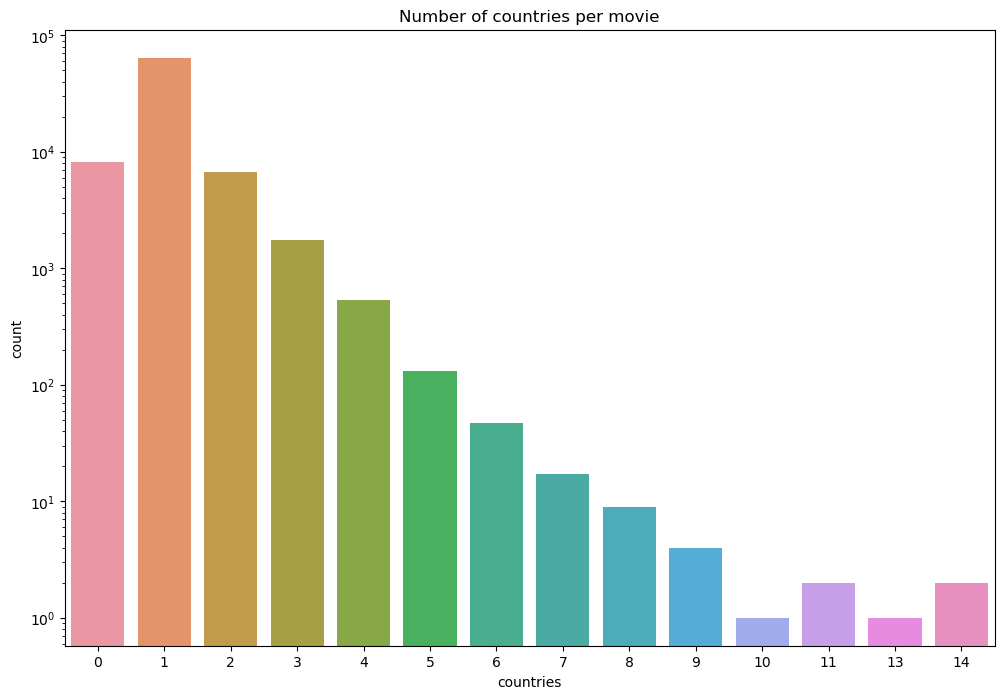

In [7]:
# Plot the bar plot of the number of countries per movie (log scale)
plt.figure(figsize=(12, 8))
plt.title("Number of countries per movie")
plt.xlabel("Number of countries")
plt.ylabel("Number of movies")
sns.countplot(x=movies_df["countries"].apply(len))
plt.yscale('log')
plt.show()

Another thing that we saw, is that 'United States of America' are frequently part of the countries of a movie. 
One way to see it is to plot a heatmap of the countries of a movie.

In [8]:
movies_copy_df = movies_df.copy()
# Only keep the countries that are in the areas
movies_copy_df["countries"] = movies_copy_df["countries"].apply(lambda x: [country for country in x if country in country_to_area])
# Only keep the movies that have at least one country
movies_copy_df = movies_copy_df[movies_copy_df["countries"].apply(len) > 0]
# Only keep the movies that have countries that are not in the same area
movies_copy_df["areas"] = movies_copy_df["countries"].apply(lambda x: set([country_to_area[country] for country in x]))
movies_copy_df = movies_copy_df[movies_copy_df["areas"].apply(lambda x: len(x) > 1)]

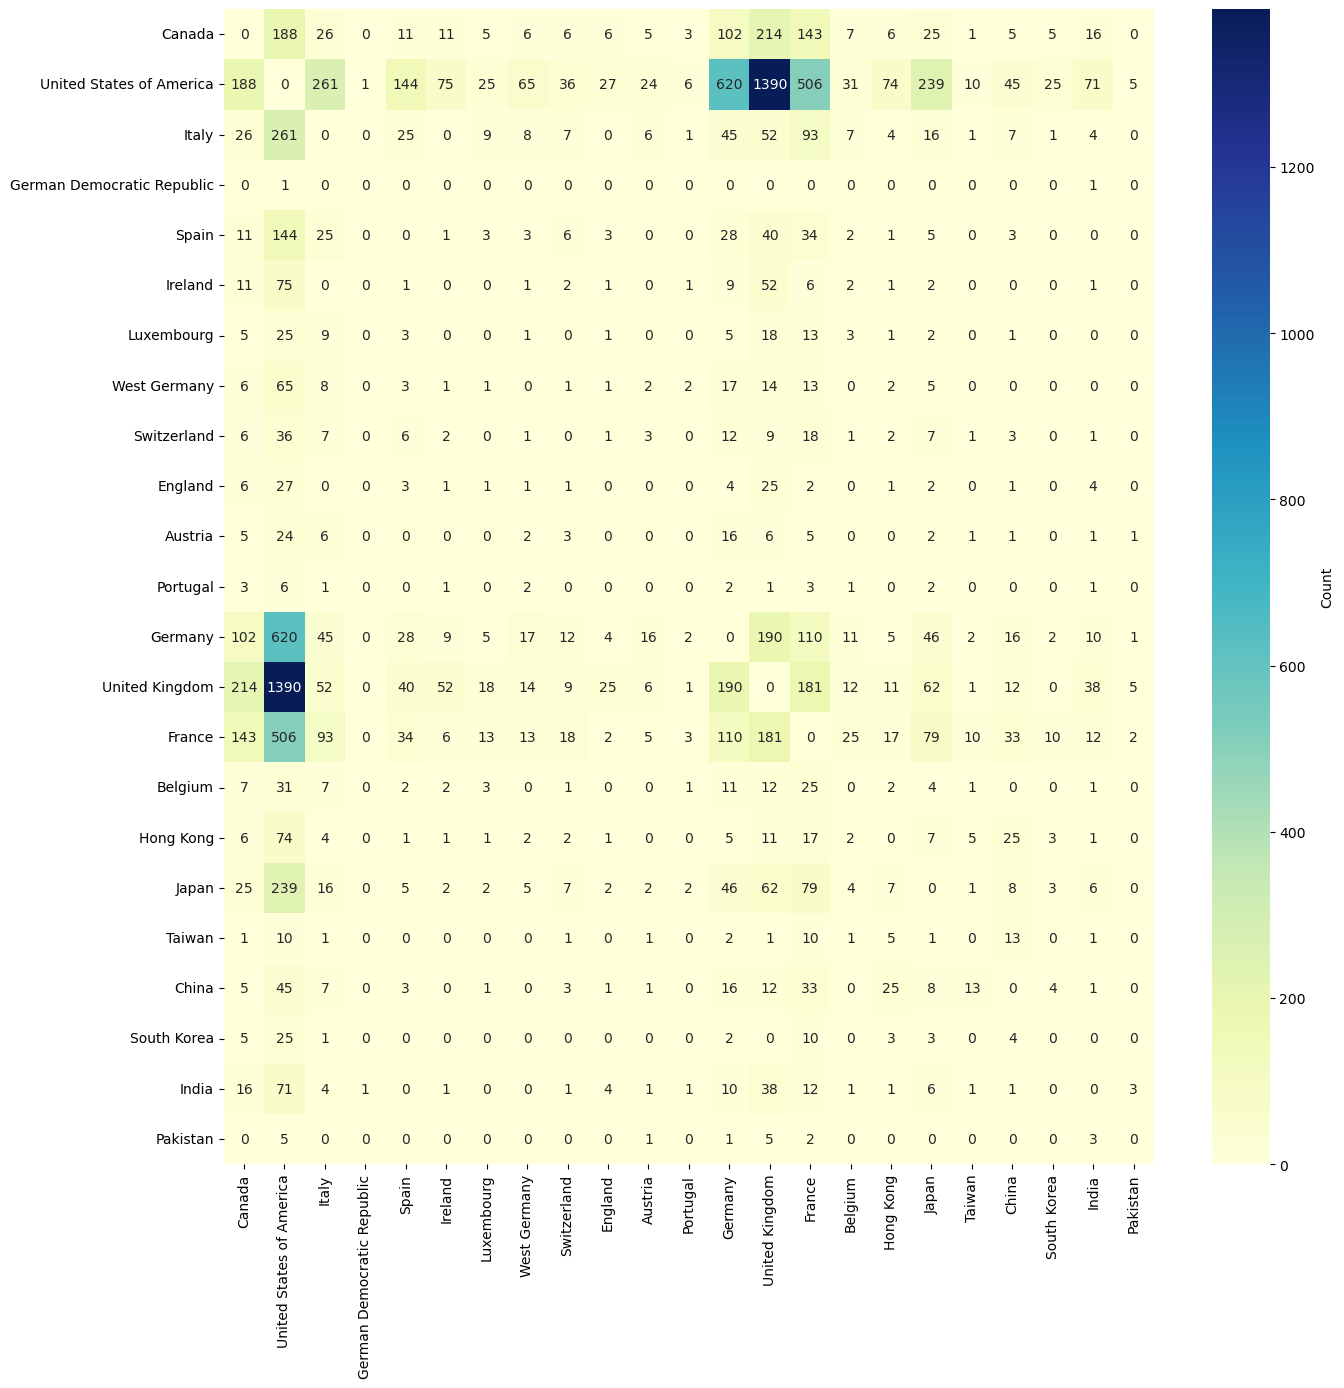

In [9]:
# Display a heatmap of the combinations of countries
countries_df = pd.DataFrame(columns=country_to_area.keys(), index=country_to_area.keys())
countries_df = countries_df.fillna(0)
for index, row in movies_copy_df.iterrows():
	countries_list = list(row["countries"])
	pairs = combinations(countries_list, 2)
	for pair in pairs:
		countries_df[pair[0]][pair[1]] += 1
		countries_df[pair[1]][pair[0]] += 1

plt.figure(figsize=(15, 15))
sns.heatmap(countries_df, annot=True, cmap="YlGnBu", fmt='g', cbar_kws={'label': 'Count'})
plt.show()

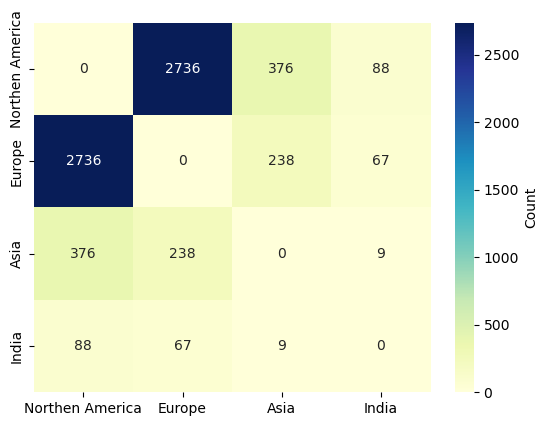

In [10]:
# Display a heatmap of the combination of areas
areas_df = pd.DataFrame(columns=areas.keys(), index=areas.keys())
areas_df = areas_df.fillna(0)
for index, row in movies_copy_df.iterrows():
	areas_list = list(row["areas"])
	pairs = list(combinations(areas_list, 2))
	for pair in pairs:
		areas_df[pair[0]][pair[1]] += 1
		areas_df[pair[1]][pair[0]] += 1

sns.heatmap(areas_df, annot=True, cmap="YlGnBu", fmt='g', cbar_kws={'label': 'Count'})
plt.show()

TODO: What can we conclude about these heatmaps?

Since nothing is specified in the dataset about what represent those countries, we will assume that we cannot choose when they are not in the same region.

One way to handle this problem is to say that if there is only one country in the list, we will use it. If there are multiple countries and every of those countries are in the same world region, we will group them in the region directly. If there are multiple countries and they are not all in the same region, we will use the Wikipedia API to get the real country of the movie.

In fact, this third option involving GET requests takes a lot of time (less than 2 movies per second), so we wanted to avoid using it as much as possible.

In [11]:
# Set default area to None
movies_df["area"] = None

print(f"There are {len(movies_df)} movies in total")

There are 81741 movies in total


In [12]:
# Set the areas if the number of countries played in is 1
movies_without_area_df = movies_df[movies_df["countries"].apply(lambda x: len(x) == 1)]
movies_df.loc[movies_without_area_df.index, "area"] = movies_without_area_df["countries"].apply(lambda x: get_area(x[0]))

print(f"Fetching areas for {len(movies_without_area_df)} movies (remaining {len(movies_df[movies_df['area'].isnull()])})")
display(movies_df.loc[movies_without_area_df.index, ["id", "countries", "area"]].head(10))

Fetching areas for 64369 movies (remaining 17372)


,id,countries,area
0,/m/03vyhn,[United States of America],Northen America
1,/m/08yl5d,[United States of America],Northen America
2,/m/0crgdbh,[Norway],Other
3,/m/0285_cd,[United Kingdom],Europe
4,/m/01mrr1,[Germany],Europe
5,/m/03cfc81,[United States of America],Northen America
6,/m/04jcqvw,[South Africa],Other
7,/m/02qc0j7,[United States of America],Northen America
8,/m/06_y2j7,[Argentina],Other
9,/m/075f66,[United Kingdom],Europe


In [13]:
def get_area_from_unanimity(countries):
	area = None
	for country in countries:
		if country in country_to_area:
			if area is None:
				area = country_to_area[country]
			elif area != country_to_area[country]:
				return None
		else:
			return None
	return area

# For each remaining movie (only the ones with None as area), if the countries played in are in the same area, set the area to that area
movies_without_area_df = movies_df[movies_df["area"].isnull()]
movies_df.loc[movies_without_area_df.index, "area"] = movies_without_area_df["countries"].apply(lambda x: get_area_from_unanimity(x))

print(f"Combining areas for {len(movies_without_area_df)} movies (remaining {len(movies_df[movies_df['area'].isnull()])})")
display(movies_df.loc[movies_without_area_df.index, ["id", "countries", "area"]].head(10))

Combining areas for 17372 movies (remaining 14423)


,id,countries,area
16,/m/0g5qvzg,[],None
26,/m/05pckh0,"[France, Italy]",Europe
33,/m/04j284s,"[United States of America, United Kingdom]",None
38,/m/0b6c_nw,"[Australia, New Zealand]",None
42,/m/0gyv1h1,[],None
47,/m/0b6kc_5,"[United States of America, Netherlands]",None
50,/m/05c4bry,[],None
53,/m/02vlsqt,"[Mexico, United States of America]",None
58,/m/05f6kpj,"[Germany, Denmark, Sweden, Norway]",None
64,/m/0dll97s,[],None


As the last step took us more than 8 hours to run, we decided to save the data in a csv file, and to load it directly in the next steps.

In [14]:
wikipedia = pywikibot.Site('en', 'wikipedia')
country_property = 'P495'

def get_area_from_wikipedia(movie_wiki_id):
	try:
		wiki_api_url = f'https://en.wikipedia.org/w/api.php?action=query&pageids={movie_wiki_id}&format=json'
		json_data = requests.get(wiki_api_url).json()
		movie_title = json_data["query"]["pages"][str(movie_wiki_id)]["title"]
		movie_page = pywikibot.Page(wikipedia, movie_title)
		movie_item = pywikibot.ItemPage.fromPage(movie_page)
		movie_item_dict = movie_item.get()
		movie_country = movie_item_dict["claims"][country_property][0].getTarget().labels["en"]
		return country_to_area[movie_country] if movie_country in country_to_area else "Other"
	except:
		return "Not found"
	
# For each remaining movie (that had the number of countries played in != 1), we set the area retrieved from wikipedia by scraping
movies_without_area_df = movies_df[movies_df["area"].isnull()]
if PERFORM_CLEANING:
	movies_df.loc[movies_without_area_df.index, "area"] = movies_without_area_df["wiki_id"].apply(lambda x: get_area_from_wikipedia(x))

print(f"Retriving areas for {len(movies_without_area_df)} movies (remaining {len(movies_df[movies_df['area'].isnull()])})")
display(movies_df.loc[movies_without_area_df.index, ["id", "countries", "area"]].head(10))

Retriving areas for 14423 movies (remaining 14423)


,id,countries,area
16,/m/0g5qvzg,[],None
33,/m/04j284s,"[United States of America, United Kingdom]",None
38,/m/0b6c_nw,"[Australia, New Zealand]",None
42,/m/0gyv1h1,[],None
47,/m/0b6kc_5,"[United States of America, Netherlands]",None
50,/m/05c4bry,[],None
53,/m/02vlsqt,"[Mexico, United States of America]",None
58,/m/05f6kpj,"[Germany, Denmark, Sweden, Norway]",None
64,/m/0dll97s,[],None
66,/m/05bzp6g,"[Australia, United Kingdom, New Zealand]",None


Now, the most part of the movies has a country and therefore a world region attached to it. It will then be used during the rest of the analysis.

### 1.2 Cleaning and reformat the data

We will now clean the data and reformat it. We will do the following steps:
- Remove the json strings
- Add a column that only contains the year of the movie
- Separate the multiple values into other dataframes (to have a database like structure)
- Save them in a csv file

In [15]:
# Separate the json columns for the movies table

# Separate the languages to another table
movies_df["languages"] = movies_df["languages"].apply(lambda x: list(json.loads(x).values())) # Convert the json string to a list of languages
movies_languages_df = movies_df[["id", "languages"]].explode("languages").reset_index(drop=True)
movies_languages_df = movies_languages_df.rename(columns={"languages": "language", "id": "movie_id"})
display(movies_languages_df.head())

# Separate the genres to another table
movies_df["genres"] = movies_df["genres"].apply(lambda x: list(json.loads(x).values())) # Convert the json string to a list of genres
movies_genres_df = movies_df[["id", "genres"]].explode("genres").reset_index(drop=True)
movies_genres_df = movies_genres_df.rename(columns={"genres": "genre", "id": "movie_id"})
display(movies_genres_df.head())

# Separate the countries to another table
# The countries are already a list of countries
movies_countries_playedin_df = movies_df[["id", "countries"]].explode("countries").reset_index(drop=True)
movies_countries_playedin_df = movies_countries_playedin_df.rename(columns={"countries": "country", "id": "movie_id"})
display(movies_countries_playedin_df.head())

# Drop the useless columns (that have been separated)
movies_df = movies_df.drop(columns=["languages", "genres", "countries"])
display(movies_df.head())

,movie_id,language
0,/m/03vyhn,English Language
1,/m/08yl5d,English Language
2,/m/0crgdbh,Norwegian Language
3,/m/0285_cd,English Language
4,/m/01mrr1,German Language


,movie_id,genre
0,/m/03vyhn,Thriller
1,/m/03vyhn,Science Fiction
2,/m/03vyhn,Horror
3,/m/03vyhn,Adventure
4,/m/03vyhn,Supernatural


,movie_id,country
0,/m/03vyhn,United States of America
1,/m/08yl5d,United States of America
2,/m/0crgdbh,Norway
3,/m/0285_cd,United Kingdom
4,/m/01mrr1,Germany


,wiki_id,id,name,release_date,revenue,runtime,area
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,Northen America
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Other
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,Europe


In [16]:
# Get year from formats 'YYYY-MM-DD' or 'YYYY'
def get_year(date: str):
	try:
		year = datetime.datetime.strptime(date, '%Y-%m-%d').year
		return year
	except:
		year = date
		return year

# Add the column release_year to the movies table
movies_df["release_year"] = movies_df["release_date"].apply(lambda x: get_year(x))
display(movies_df.head())

,wiki_id,id,name,release_date,revenue,runtime,area,release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,Northen America,2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Other,1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe,1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,Europe,1983


In [17]:
# Store the summaries of the movies in a separate table, using the movie_id instead of the wiki_id
# We could have directly merged the summaries with the movies table, but it is a very large text field

# Load the summaries
movies_summaries_df = pd.read_csv(DATA_PATH + 'plot_summaries.txt', delimiter='\t', header=None, names=['wiki_id', 'summary'])
display(movies_summaries_df.head())

# Merge the summaries with the movies table, to change the wiki_id to movie_id
movies_summaries_df = movies_summaries_df.merge(movies_df[["wiki_id", "id"]], on="wiki_id")
movies_summaries_df = movies_summaries_df.drop(columns=["wiki_id"])
movies_summaries_df = movies_summaries_df.rename(columns={"id": "movie_id"})
display(movies_summaries_df.head())

,wiki_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


,summary,movie_id
0,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb
1,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s
2,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb
3,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3
4,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5


In [18]:
# Store the characters in a separate table

# Load the characters
characters_df = pd.read_csv(DATA_PATH + 'character.metadata.tsv', delimiter='\t', header=None, names=['movie_wiki_id', 'movie_id', 'movie_release_date', 'name', 'actor_birth_date', 'actor_gender', 'actor_height','actor_ethinicity_id', 'actor_name', 'actor_age', 'actor_map_id', 'id', 'actor_id']) 
display(characters_df.head())

,movie_wiki_id,movie_id,movie_release_date,name,actor_birth_date,actor_gender,actor_height,actor_ethinicity_id,actor_name,actor_age,actor_map_id,id,actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [19]:
# Clean the characters categories table

# Load the characters categories
characters_categories_df = pd.read_csv(DATA_PATH + 'tvtropes.clusters.txt', delimiter='\t', header=None, names=['category', 'meta'])
display(characters_categories_df.head())

# Fetch the characters ids from the meta column, and remove the other information that are redundant with the characters table
characters_categories_df["meta"] = characters_categories_df["meta"].apply(lambda x: json.loads(x))
characters_categories_df["character_id"] = characters_categories_df["meta"].apply(lambda x: x["id"])
characters_categories_df = characters_categories_df.drop(columns=["meta"])
display(characters_categories_df.head())

,category,meta
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


,category,character_id
0,absent_minded_professor,/m/0jy9q0
1,absent_minded_professor,/m/02vchl3
2,absent_minded_professor,/m/0k6fkc
3,absent_minded_professor,/m/0k6_br
4,absent_minded_professor,/m/0k3rhh


It is now time to save everything in a csv file, so that we can load it in the next steps.

In [20]:
if PERFORM_CLEANING:
	# Make sure to create the clean_data folder before running this script
	
	# Remove all the previous files from the clean_data folder
	for filename in os.listdir(CLEAN_DATA_PATH):
		os.remove(CLEAN_DATA_PATH + filename)

	# Save the data
	movies_df.to_csv(CLEAN_DATA_PATH + 'movies.csv', index=False)
	movies_languages_df.to_csv(CLEAN_DATA_PATH + 'movies_languages.csv', index=False)
	movies_genres_df.to_csv(CLEAN_DATA_PATH + 'movies_genres.csv', index=False)
	movies_countries_playedin_df.to_csv(CLEAN_DATA_PATH + 'movies_countries_playedin.csv', index=False)
	movies_summaries_df.to_csv(CLEAN_DATA_PATH + 'movies_summaries.csv', index=False)
	characters_df.to_csv(CLEAN_DATA_PATH + 'characters.csv', index=False)
	characters_categories_df.to_csv(CLEAN_DATA_PATH + 'characters_categories.csv', index=False)

To see what we did, here is a little overview of the tables related to the movies:
- movies.csv
- movies_countries_playedin.csv
- movies_genres.csv
- movies_languages.csv
- movies_summaries.csv

To use all of those tables (except movies), we will need to merge them to the movie table (in a database like structure).

In [21]:
movies_df = pd.read_csv(CLEAN_DATA_PATH + 'movies.csv')
display(movies_df.head())

# Add the language to the movies table
languages_df = pd.read_csv(CLEAN_DATA_PATH + 'movies_languages.csv')
movies_df = pd.merge(movies_df, languages_df, left_on="id", right_on="movie_id", how="left")
display(movies_df.head())

,wiki_id,id,name,release_date,revenue,runtime,area,release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,Northen America,2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Other,1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe,1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,Europe,1983


,wiki_id,id,name,release_date,revenue,runtime,area,release_year,movie_id,language
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,English Language
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,Northen America,2000,/m/08yl5d,English Language
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Other,1988,/m/0crgdbh,Norwegian Language
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe,1987,/m/0285_cd,English Language
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,Europe,1983,/m/01mrr1,German Language


In this example, the languages can be multiple for a single movie, so the joined table will have multiple rows for a single movie.

### 1.3 Data exploration and visualization


The groundwork is now in place for easy data accessibility, given our planned analysis. It's time to dive deeper into our data. Our initial focus is dual: evaluating data integrity, particularly regarding missing data, and gaining an overview of its characteristics. We will sequentially assess the following  parameters—film box-office revenue, movie genre, actor gender, and actor ethnicity — than we plan to integrate within our data story. This stage serves as a critical precursor, guiding us to identify parameters suitable for exploration in the next milestone and determining the direction that our next analysis will take. 

#### 1.3.1 Exploration of the box-office revenue of movies

First, we need separate the data and create individuals dataframe from the movies dataframe for each geographical region previously defined, using the area feature added before.

In [28]:
#Load the data
movies_df = pd.read_csv(CLEAN_DATA_PATH + 'movies.csv')

#Create a separate dataframe with data of each area
movies_revenue_df=movies_df.copy()
asia_movies_df = movies_revenue_df[movies_revenue_df["area"] == "Asia"]
europe_movies_df = movies_revenue_df[movies_revenue_df["area"] == "Europe"]
india_movies_df = movies_revenue_df[movies_revenue_df["area"] == "India"]
northen_america_movies_df = movies_revenue_df[movies_revenue_df["area"] == "Northen America"]

display(asia_movies_df.head())
display(europe_movies_df.head())
display(india_movies_df.head())
display(northen_america_movies_df.head())

,wiki_id,id,name,release_date,revenue,runtime,area,release_year
11,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,Asia,1974
43,26878691,/m/0f400r,Mysterious Island,1982,NaN,100.0,Asia,1982
56,13281430,/m/03c0d85,My Name is Fame,2006,NaN,94.0,Asia,2006
108,24196090,/m/07k8x7p,The World of Geisha,1973-11-03,NaN,73.0,Asia,1973
114,17780234,/m/0479c20,Banana Club,1996-04-13,NaN,NaN,Asia,1996


,wiki_id,id,name,release_date,revenue,runtime,area,release_year
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe,1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,Europe,1983
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,Europe,1960
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,Europe,1989
16,30388930,/m/0g5qvzg,1919,1984,NaN,99.0,Europe,1984


,wiki_id,id,name,release_date,revenue,runtime,area,release_year
27,20604092,/m/0523t_1,Anbu Thozhi,2007-08-17,NaN,NaN,India,2007
30,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,India,1984
31,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,India,1989
35,29528534,/m/04j0lfk,Anokha Rishta,1986,NaN,180.0,India,1986
37,29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,NaN,110.0,India,2010


,wiki_id,id,name,release_date,revenue,runtime,area,release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,Northen America,2000
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,Northen America,1913
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,Northen America,1938
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,Northen America,1930


Before performing any analysis on this feature, we need to check if there are some missing box-office revenue data. If so, we need to determine to which extent, in order to decide the best way to handle it, and determine how it could impact our analysis.

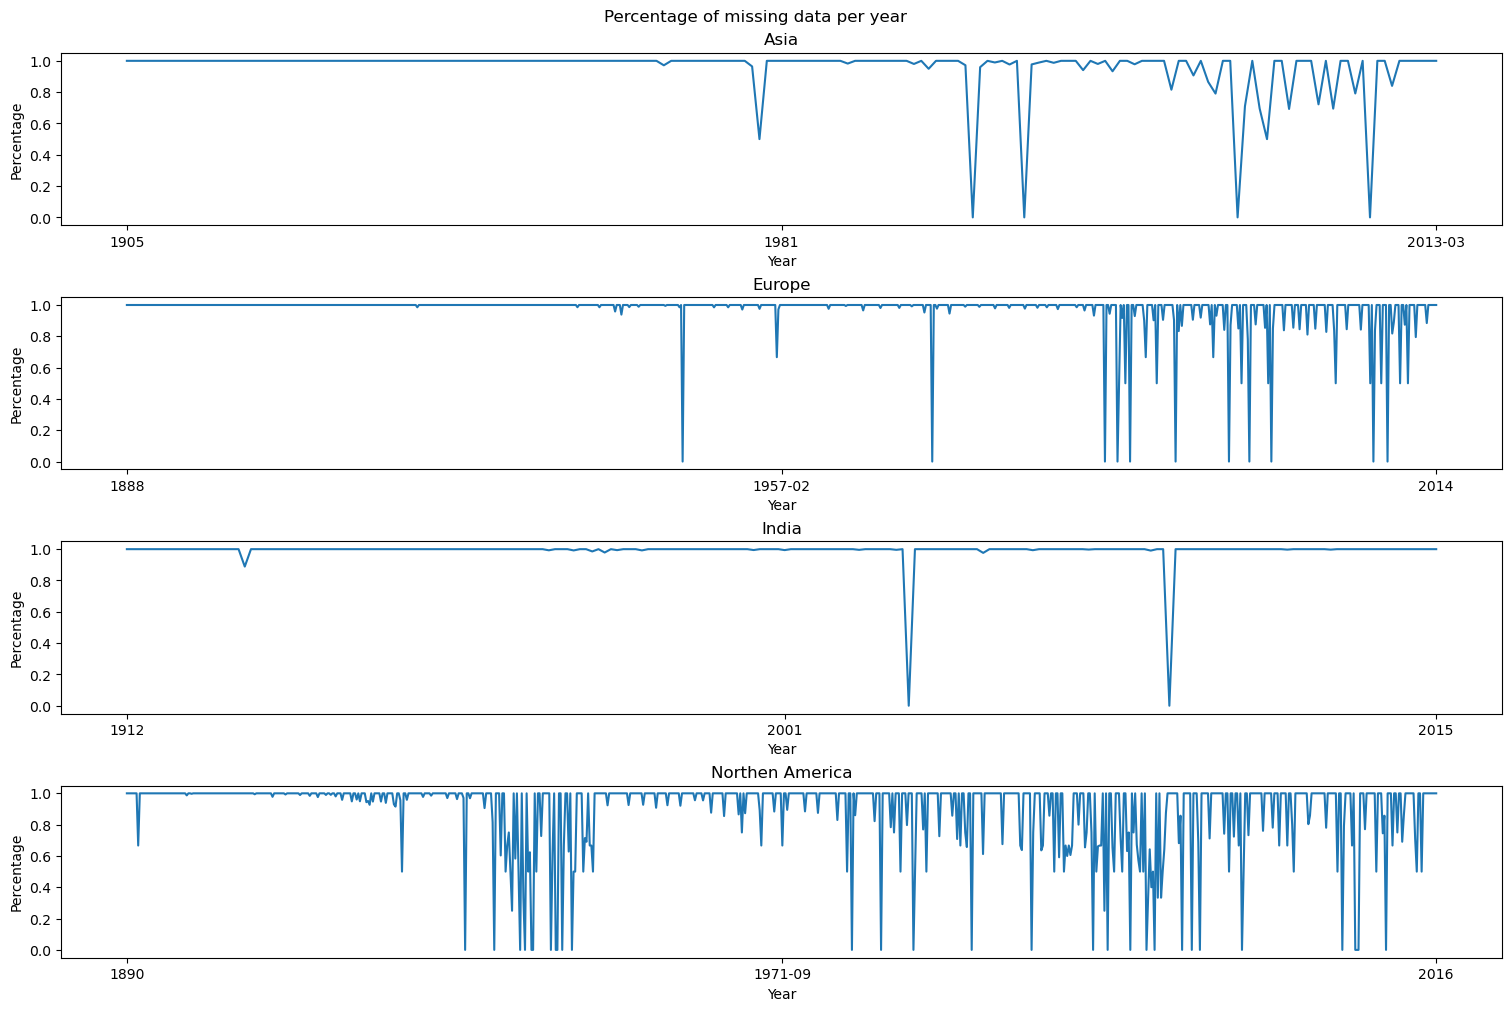

Percentage of missing revenue data:
- Asia: 90.86
- Europe: 93.74
- India: 99.67
- Northen America: 82.19


In [43]:
# compute the proportion of missing revenue data
def percentage_missing_data(df, region, ax):
    # Indicator variable showing that something is NA
    df.loc[:,["revenue_is_na"]] = df.revenue.isna()

    # % of missing data
    missing_revenue_data = df.groupby("release_year").revenue_is_na.mean()
    
    # Plot it
    ax.plot(missing_revenue_data)
    ax.set(xlabel='Year', ylabel='Percentage')
    ax.set_title(region)
    x_values = ax.get_xticks()
    new_x = [x_values[i] for i in [0, len(x_values) //2, -1]]
    ax.set_xticks(new_x)
    
    #return overall percentage of missing data
    prop_missing_data=sum(df["revenue_is_na"])*100/len(df)
    return prop_missing_data

fig, axs = plt.subplots(4, sharey=True, figsize=(15, 10), layout='constrained')
fig.suptitle("Percentage of missing data per year")
prop_missing_asia=percentage_missing_data(asia_movies_df, "Asia", axs[0])
prop_missing_europe=percentage_missing_data(europe_movies_df, "Europe", axs[1])
prop_missing_india=percentage_missing_data(india_movies_df, "India", axs[2])
prop_missing_northen_america=percentage_missing_data(northen_america_movies_df, "Northen America", axs[3])
plt.show()

# PrintOverall proportion of missing data
print("Percentage of missing revenue data:")
print("- Asia: %.2f" % prop_missing_asia)
print("- Europe: %.2f" % prop_missing_europe)
print("- India: %.2f" % prop_missing_india)
print("- Northen America: %.2f" % prop_missing_northen_america)

In general, the data exhibits a lot of missing values, ranging from 82.19% to 99.67% across various regions. Particularly noteworthy is the near 100% absence of revenue data for India, as well as substantial gaps over extended timeframes in the other regions. Consequently, conducting a meaningful analysis becomes unfeasible. The dataset lacks uniformity in revenue representation among areas, and represents only select years. As a result, we've opted against analyzing film revenue and instead shifted focus to other parameters that offer richer insights.

#### 1.3.2 Exploration of the movie genres

In [44]:
# Load the data
genres_df = pd.read_csv(CLEAN_DATA_PATH + 'movies_genres.csv')
display(genres_df.head())

#Merge movie genre to movie dataset
movies_genres_df = pd.merge(movies_df, genres_df, left_on="id", right_on="movie_id", how="left")
display(movies_genres_df.head())

,movie_id,genre
0,/m/03vyhn,Thriller
1,/m/03vyhn,Science Fiction
2,/m/03vyhn,Horror
3,/m/03vyhn,Adventure
4,/m/03vyhn,Supernatural


,wiki_id,id,name,release_date,revenue,runtime,area,release_year,movie_id,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Thriller
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Science Fiction
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Horror
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Adventure
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Supernatural


Similarly to the movie revenue, we separate the data by creating individuals dataframe from the movies dataframe for each geographical region previously defined.

In [45]:
asia_genres_df = movies_genres_df[movies_genres_df["area"] == "Asia"]
display(asia_genres_df.head())
europe_genres_df = movies_genres_df[movies_genres_df["area"] == "Europe"]
display(europe_genres_df.head())
india_genres_df = movies_genres_df[movies_genres_df["area"] == "India"]
display(india_genres_df.head())
northen_america_genres_df = movies_genres_df[movies_genres_df["area"] == "Northen America"]
display(northen_america_genres_df.head())

,wiki_id,id,name,release_date,revenue,runtime,area,release_year,movie_id,genre
36,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,Asia,1974,/m/07kjkz6,Crime Fiction
37,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,Asia,1974,/m/07kjkz6,Thriller
38,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,Asia,1974,/m/07kjkz6,Japanese Movies
39,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,Asia,1974,/m/07kjkz6,World cinema
40,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974,NaN,89.0,Asia,1974,/m/07kjkz6,Action/Adventure


,wiki_id,id,name,release_date,revenue,runtime,area,release_year,movie_id,genre
13,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe,1987,/m/0285_cd,Thriller
14,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe,1987,/m/0285_cd,Erotic thriller
15,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,Europe,1987,/m/0285_cd,Psychological thriller
16,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,Europe,1983,/m/01mrr1,Drama
32,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,Europe,1960,/m/075f66,Horror


,wiki_id,id,name,release_date,revenue,runtime,area,release_year,movie_id,genre
93,20604092,/m/0523t_1,Anbu Thozhi,2007-08-17,NaN,NaN,India,2007,/m/0523t_1,Romance Film
99,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,India,1984,/m/02rc_h4,Family Film
100,11448183,/m/02rc_h4,Bindiya Chamkegi,1984-01-20,NaN,NaN,India,1984,/m/02rc_h4,Comedy
101,9633533,/m/02pml15,Vandanam,1989,NaN,168.0,India,1989,/m/02pml15,Action
111,29528534,/m/04j0lfk,Anokha Rishta,1986,NaN,180.0,India,1986,/m/04j0lfk,World cinema


,wiki_id,id,name,release_date,revenue,runtime,area,release_year,movie_id,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Thriller
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Science Fiction
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Horror
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Adventure
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,Northen America,2001,/m/03vyhn,Supernatural


As for the revenue, before performing any analysis on this caracteristic, we need to determine the proportion of missing data.

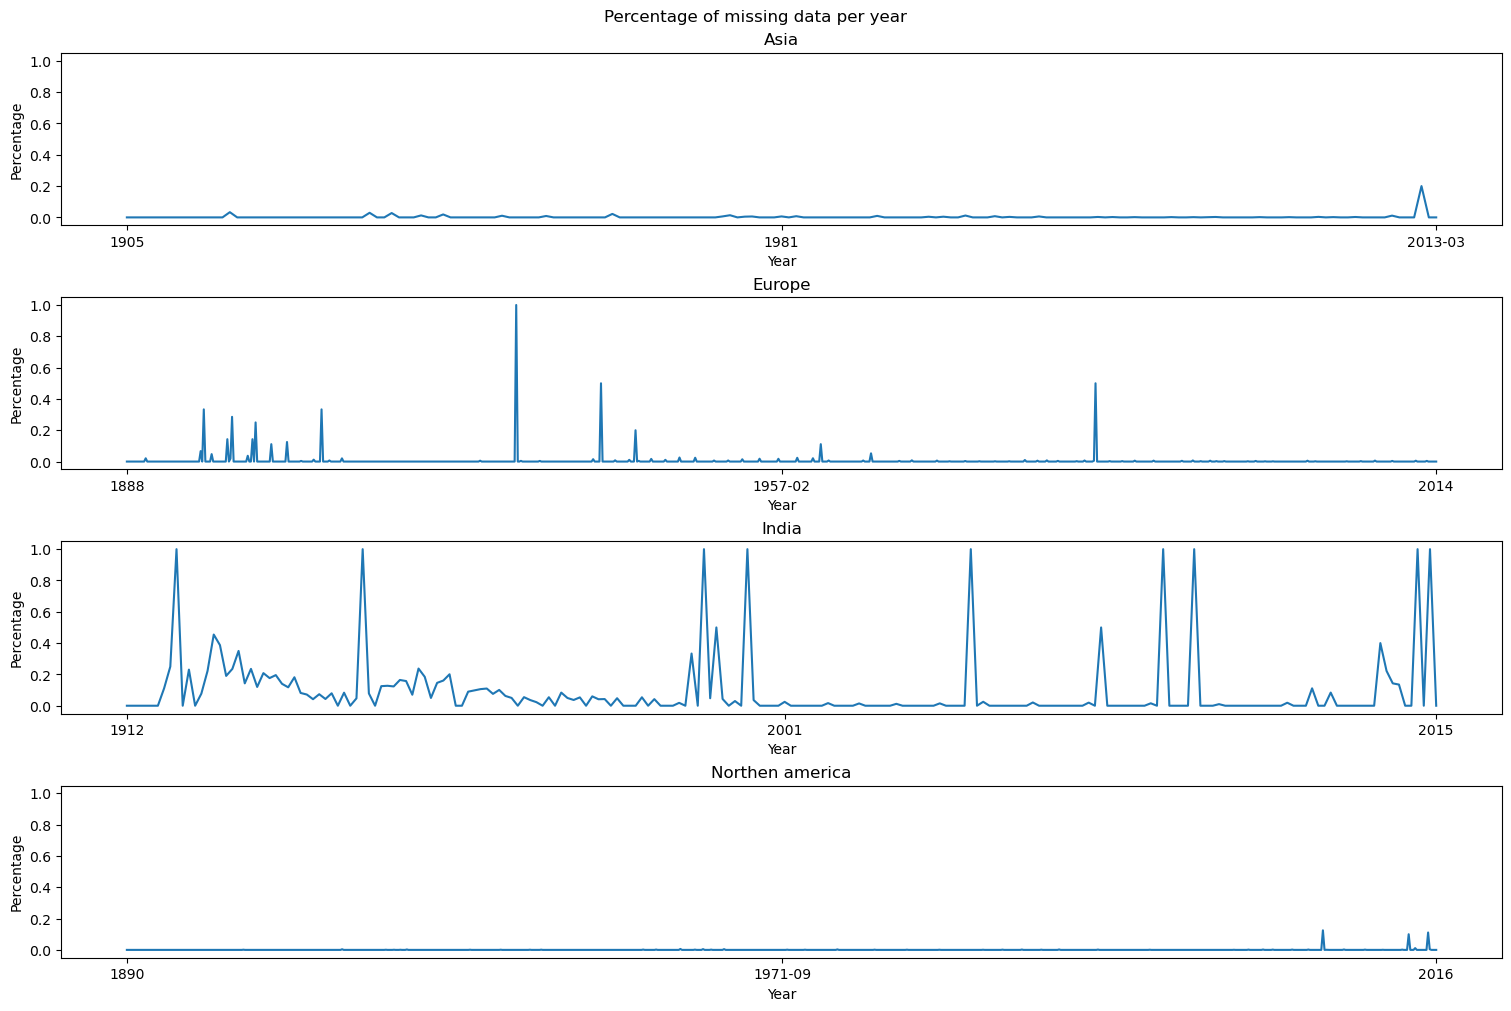

Percentage of missing data for genre:
- Asia: 0.43
- Europe: 0.60
- India: 5.73
- Northen America: 0.17


In [46]:
#Function to compute the proportion of missing data about movie genre
def percentage_missing_data(df, region, ax):
    # Indicator variable showing that something is NA
    df.loc[:,["genre_is_na"]] = df.genre.isna()

    # % of missing data
    missing_genre_data = df.groupby("release_year").genre_is_na.mean()
    
    # Plot it
    ax.plot(missing_genre_data)
    ax.set(xlabel='Year', ylabel='Percentage')
    ax.set_title(region)
    x_values = ax.get_xticks()
    new_x = [x_values[i] for i in [0, len(x_values) //2, -1]]
    ax.set_xticks(new_x)
    
    #Compute overall percentage of missing data
    tot_missing_data=sum(df["genre_is_na"])*100/len(df)
    return tot_missing_data

fig, axs = plt.subplots(4, sharey=True, figsize=(15, 10), layout='constrained')
fig.suptitle("Percentage of missing data per year")
prop_tot_asia = percentage_missing_data(asia_genres_df, "Asia", axs[0])
prop_tot_europe = percentage_missing_data(europe_genres_df, "Europe", axs[1])
prop_tot_india = percentage_missing_data(india_genres_df, "India", axs[2])
prop_tot_northen_america = percentage_missing_data(northen_america_genres_df, "Northen america", axs[3])
plt.show()

print("Percentage of missing data for genre:")
print("- Asia: %.2f" % prop_tot_asia)
print("- Europe: %.2f" % prop_tot_europe)
print("- India: %.2f" % prop_tot_india)
print("- Northen America: %.2f" % prop_tot_northen_america)

The absence of data for movie genres is notably minimal, varying between 0.17% to 5.73%. Indian -the only area surpassing  1%- display a slightly higher absence at 5.73%, yet it remains within reasonable bounds. Moreover, the missing data appear evenly spread across the years. Consequently, we've chosen to eliminate these movies from the subsequent phase of genre analysis.

In [47]:
#Get rid of movies whose genre is not specified
print("Removing films from which the genre is not specified:")
print("- Number of Asian movies before:", len(asia_genres_df))
asia_genres_df=asia_genres_df[~asia_genres_df["genre_is_na"]]
print("- Number of Asian movies after:", len(asia_genres_df))

print("- Number of European movies before:", len(europe_genres_df))
europe_genres_df=europe_genres_df[~europe_genres_df["genre_is_na"]]
print("- Number of European movies after:", len(europe_genres_df))

print("- Number of Indian movies before:", len(india_genres_df))
india_genres_df=india_genres_df[~india_genres_df["genre_is_na"]]
print("- Number of Indian movies after:", len(india_genres_df))

print("- Number of Northen American movies before:", len(northen_america_genres_df))
northen_america_genres_df=northen_america_genres_df[~northen_america_genres_df["genre_is_na"]]
print("- Number of Northen American movies after:", len(northen_america_genres_df))

Removing films from which the genre is not specified:
- Number of Asian movies before: 17192
- Number of Asian movies after: 17118
- Number of European movies before: 45123
- Number of European movies after: 44851
- Number of Indian movies before: 21236
- Number of Indian movies after: 20020
- Number of Northen American movies before: 132478
- Number of Northen American movies after: 132254


With missing data addressed, it's time to have an overview of diverse movie genres across various geographical areas! First, let's have a look at the number of genres in each area, and the quantity of movies belonging to each of them.

In [49]:
# For each region, group the movies by their genre, and count the number of movies per genre
def group_by_genre(genre_df):
    genre_count = genre_df.explode('genre')
    genre_count = genre_df.groupby('genre').count()['id'].reset_index()
    genre_count = genre_count.rename(columns={'id': 'movies_count'})
    genre_count = genre_count.sort_values('movies_count', ascending=False)
    display(genre_count.head(10))
    return genre_count
    
asia_genre_count=group_by_genre(asia_genres_df)
europe_genre_count=group_by_genre(europe_genres_df)
india_genre_count=group_by_genre(india_genres_df)
northen_america_genre_count=group_by_genre(northen_america_genres_df)

#Print the number of different genres
print("Number of genre categories for Asian film: ", len(asia_genre_count))
print("Number of genre categories for European film: ", len(europe_genre_count))
print("Number of genre categories for Indian film: ", len(india_genre_count))
print("Number of genre categories for Northen American film: ", len(northen_america_genre_count))

,genre,movies_count
119,Japanese Movies,2104
71,Drama,1846
201,World cinema,1437
36,Chinese Movies,1389
0,Action,979
38,Comedy,624
3,Action/Adventure,621
126,Martial Arts Film,545
157,Romance Film,534
191,Thriller,489


,genre,movies_count
96,Drama,7726
60,Comedy,2987
306,World cinema,1975
250,Romance Film,1937
294,Thriller,1740
83,Crime Fiction,1722
63,Comedy film,1250
36,Black-and-white,1208
92,Documentary,1201
262,Short Film,1072


,genre,movies_count
51,Drama,4992
120,Romance Film,2148
152,World cinema,1924
0,Action,1712
18,Bollywood,1312
100,Musical,1289
26,Comedy,978
146,Thriller,838
122,Romantic drama,720
63,Family Film,580


,genre,movies_count
107,Drama,13460
69,Comedy,9767
42,Black-and-white,6140
284,Short Film,5813
185,Indie,5523
319,Thriller,4889
2,Action,4482
268,Romance Film,4417
92,Crime Fiction,3630
285,Silent film,3629


Number of genre categories for Asian film:  204
Number of genre categories for European film:  308
Number of genre categories for Indian film:  153
Number of genre categories for Northen American film:  337


There's quite a variety of genres here! To streamline our analysis, we'll eliminate those that have very little representation, focusing instead on the primary movie genres in each geographical region. We'll retain genres that appear in at least 2% of the films for this purpose.

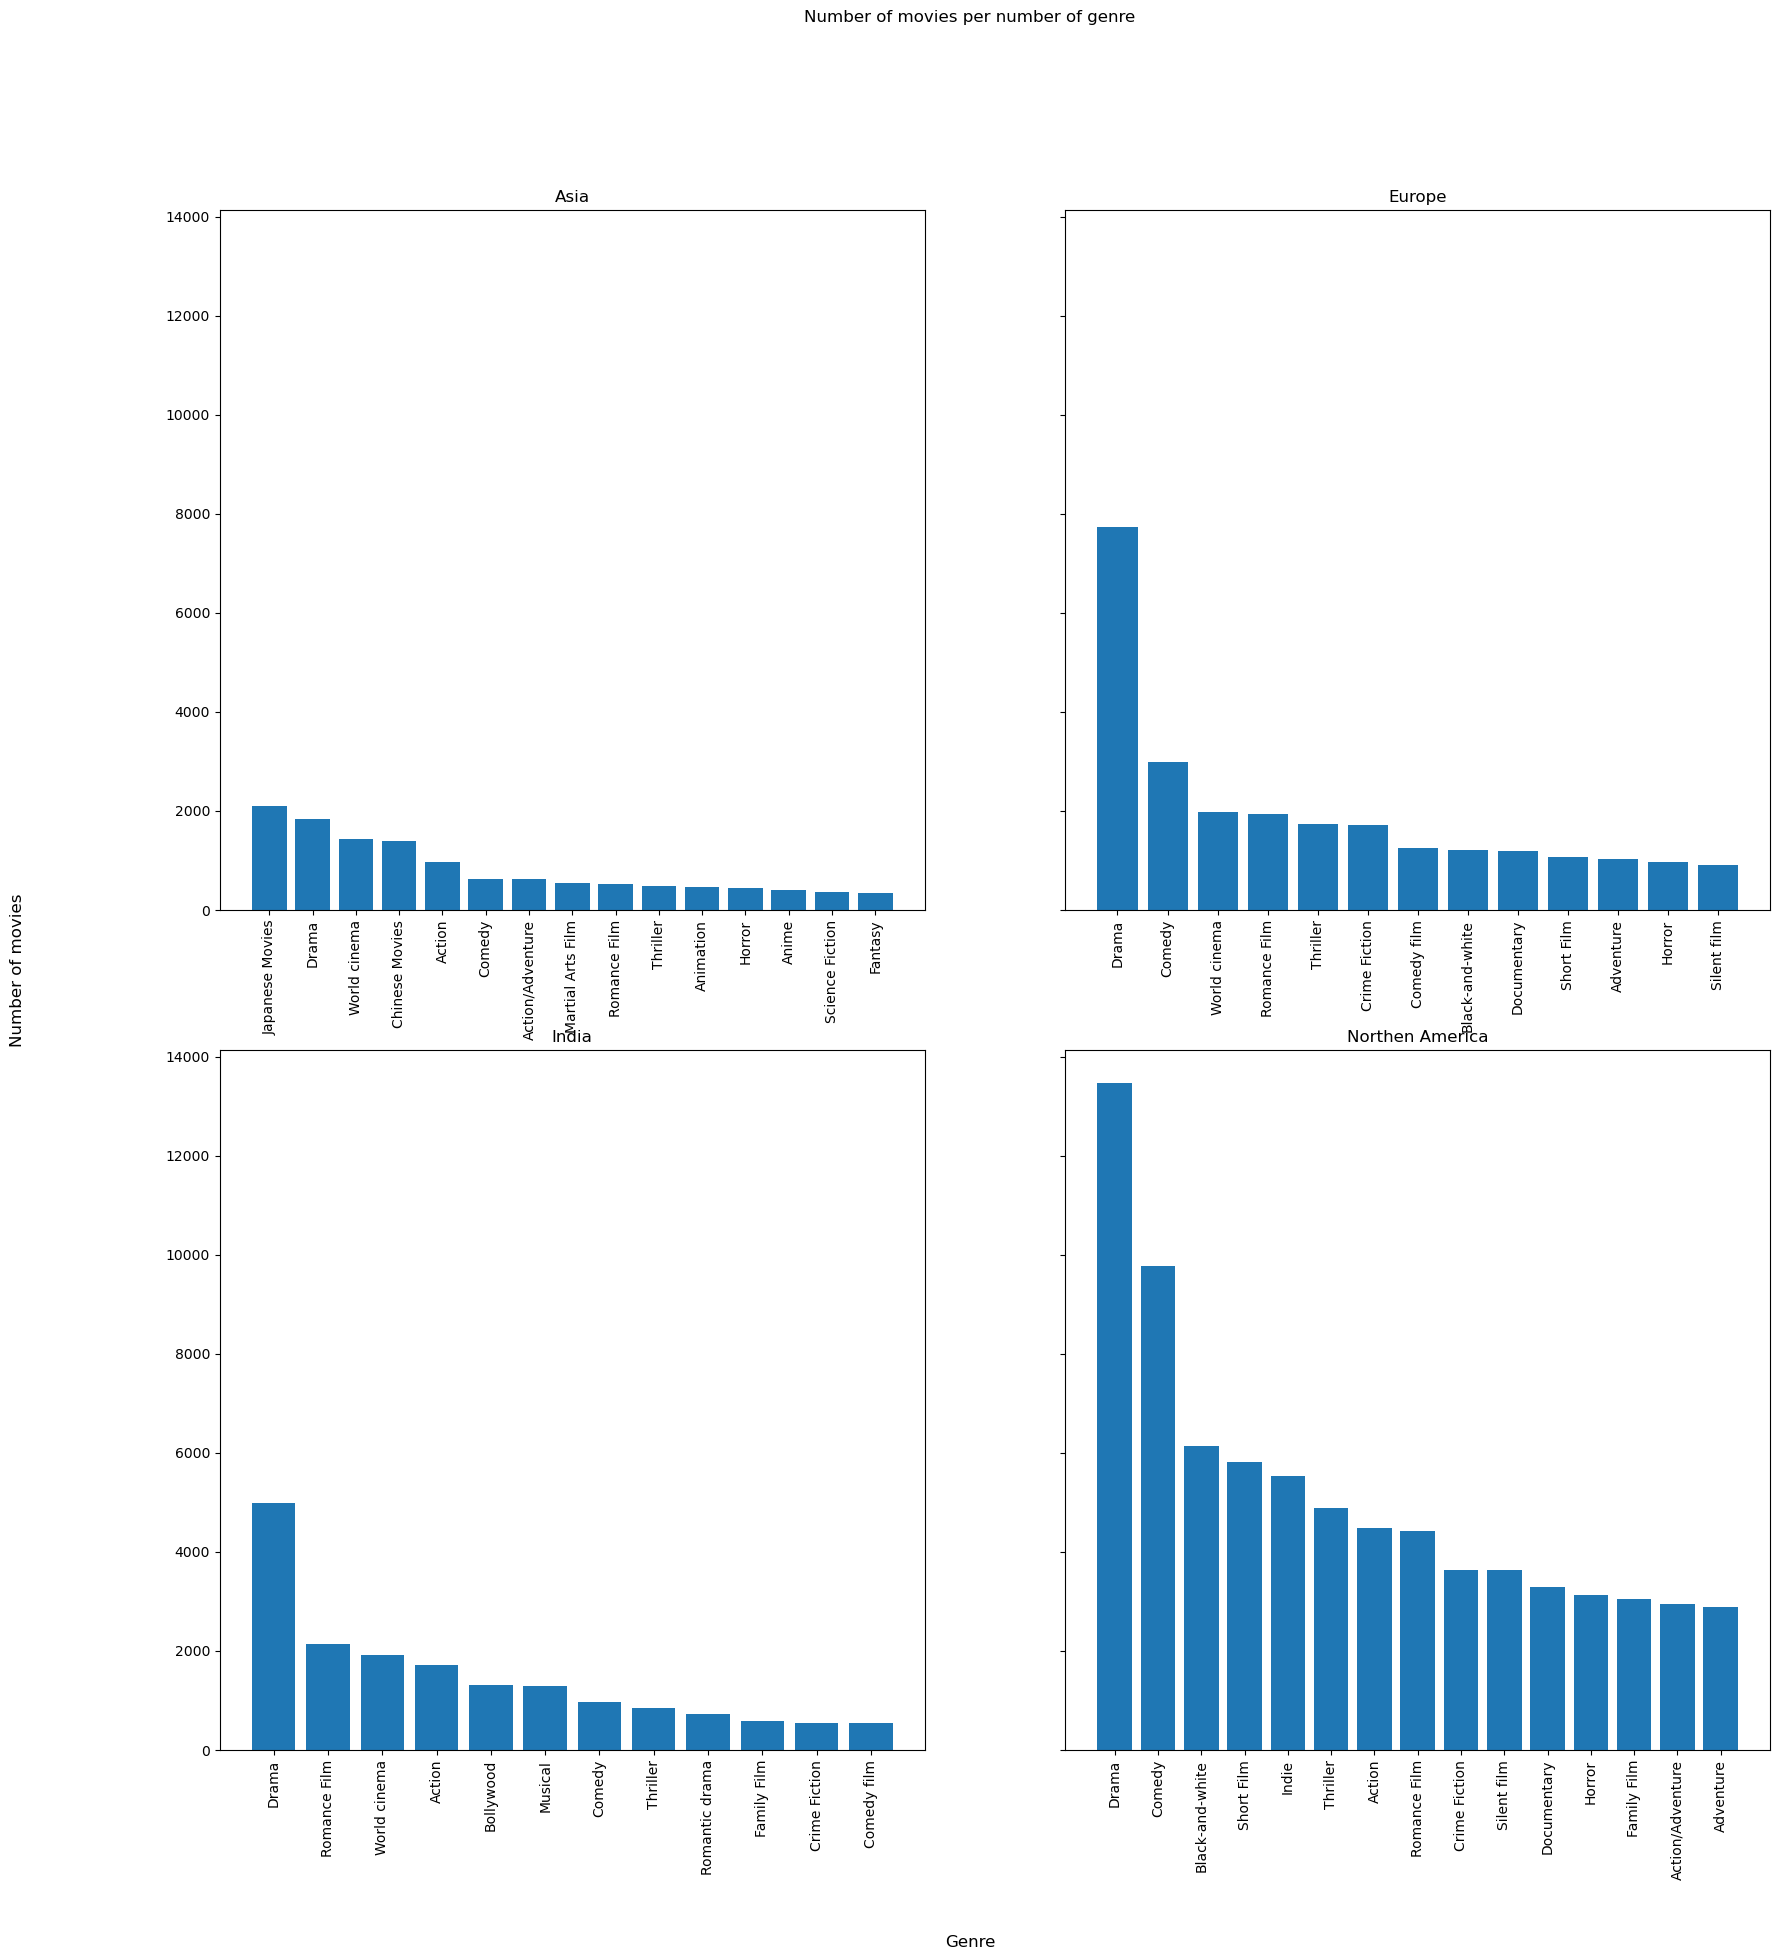

In [50]:
#Keep only genre that represents 1% of the movie
asia_genre_count=asia_genre_count[asia_genre_count["movies_count"]/asia_genre_count["movies_count"].sum()>0.02]
europe_genre_count=europe_genre_count[europe_genre_count["movies_count"]/europe_genre_count["movies_count"].sum()>0.02]
india_genre_count=india_genre_count[india_genre_count["movies_count"]/india_genre_count["movies_count"].sum()>0.02]
northen_america_genre_count=northen_america_genre_count[northen_america_genre_count["movies_count"]/northen_america_genre_count["movies_count"].sum()>0.02]

#Overview of those genres
fig, ax=plt.subplots(2,2, figsize=(20, 20), sharey=True)
ax[0][0].bar(asia_genre_count.genre, asia_genre_count.movies_count)
ax[0][0].tick_params(axis='x', rotation=90)
ax[0][0].set_title('Asia')
ax[0][1].bar(europe_genre_count.genre, europe_genre_count.movies_count)
ax[0][1].tick_params(axis='x', rotation=90)
ax[0][1].set_title('Europe')
ax[1][0].bar(india_genre_count.genre, india_genre_count.movies_count)
ax[1][0].tick_params(axis='x', rotation=90)
ax[1][0].set_title('India')
ax[1][1].bar(northen_america_genre_count.genre, northen_america_genre_count.movies_count)
ax[1][1].tick_params(axis='x', rotation=90)
ax[1][1].set_title('Northen America')
fig.supxlabel('Genre')
fig.supylabel('Number of movies')
fig.suptitle('Number of movies per number of genre')
#plt.grid(linestyle='--', alpha=0.7)
#plt.yscale('log')
plt.show()

We can notice prevalent genres shared across geographical areas, such as drama consistently ranking in the top 3 for each region. However, certain genres appear more region-specific, like martial arts in Asia or Westerns in North America. Exploring these commonalities and differences will be a focal point in the upcoming project milestone as we delve deeper into the analysis.